# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/workspace/circuit-finder")

# Load Dataset


In [3]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult


def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

In [4]:
import pathlib
import pandas as pd
from circuit_finder.experiments.run_dataset_sweep import SELECTED_DATASETS
from circuit_finder.paper.run_leap_experiment_batched import THRESHOLDS

SWEEP_NAMES = [
    "corrupt_keep_error",
    "corrupt_ablate_error",
    "tokenwise_keep_error",
    "tokenwise_ablate_error",
    "c4_keep_error",
    "c4_ablate_error",
    "D_keep_error",
    "D_ablate_error",
]


rows = []
for sweep_name in SWEEP_NAMES:
    for dataset_path in SELECTED_DATASETS:
        dataset_name = pathlib.Path(dataset_path).stem
        for threshold in THRESHOLDS:
            try:
                result = load_result(dataset_name, threshold, sweep_name)
            except FileNotFoundError:
                continue
            num_nodes = len(result.graph.get_src_nodes()) + len(
                result.error_graph.get_src_nodes()
            )
            rows.append(
                {
                    "sweep_name": sweep_name,
                    "dataset": dataset_name,
                    "threshold": threshold,
                    "num_nodes": num_nodes,
                    "clean_metric": result.clean_metric,
                    "graph_ablated_metric": result.graph_ablated_metric,
                    "fully_ablated_metric": result.fully_ablated_metric,
                }
            )

df = pd.DataFrame(rows)
df.head()

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.001,3430,4.267218,5.908043,1.542635
1,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.003,1974,4.267218,6.235228,1.542635
2,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.006,1376,4.267218,6.128921,1.542635
3,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.010,992,4.267218,5.933163,1.542635
4,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.030,377,4.267218,5.363180,1.542635


In [5]:
df

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.001,3430,4.267218,5.908043,1.542635
1,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.003,1974,4.267218,6.235228,1.542635
2,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.006,1376,4.267218,6.128921,1.542635
3,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.010,992,4.267218,5.933163,1.542635
4,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.030,377,4.267218,5.363180,1.542635
5,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.060,220,4.267218,4.992482,1.542635
6,corrupt_keep_error,ioi_ABBA_template_0_prompts,0.100,142,4.267218,4.984550,1.542635


# Faithfulness Curves

For each sweep and dataset, we want to plot faithfulness over many different settings. 

In [6]:
df["faithfulness"] = (df["graph_ablated_metric"] - df["fully_ablated_metric"]) / (
    df["clean_metric"] - df["fully_ablated_metric"]
)

/tmp/ipykernel_209125/163401420.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
/tmp/ipykernel_209125/163401420.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
/tmp/ipykernel_209125/163401420.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
/tmp/ipykernel_209125/163401420.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend

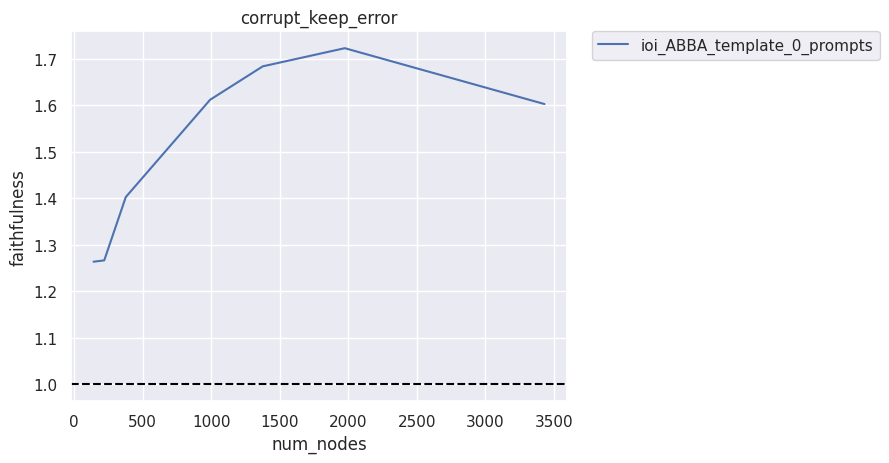

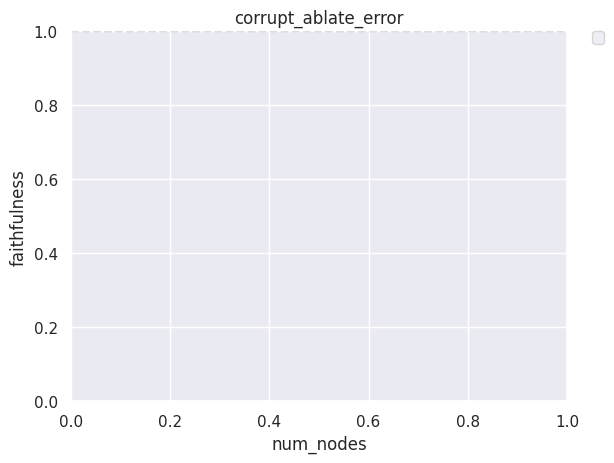

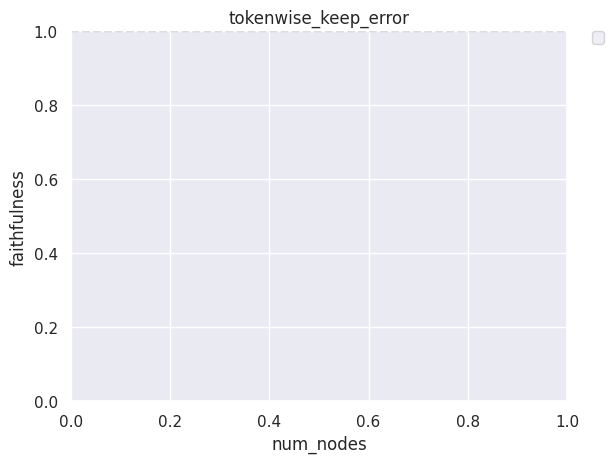

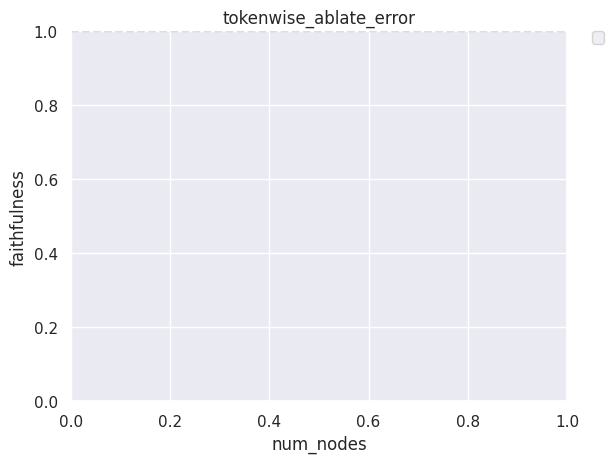

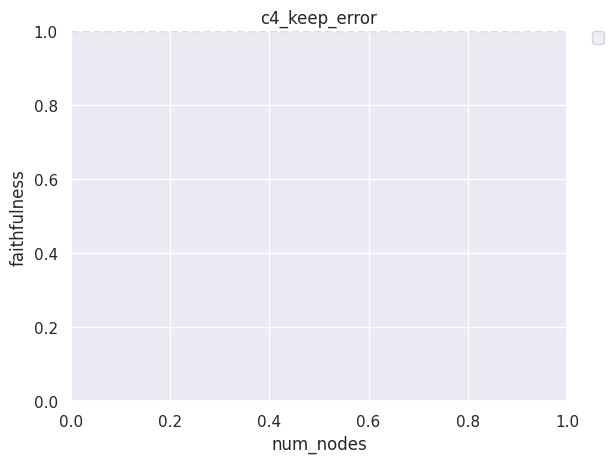

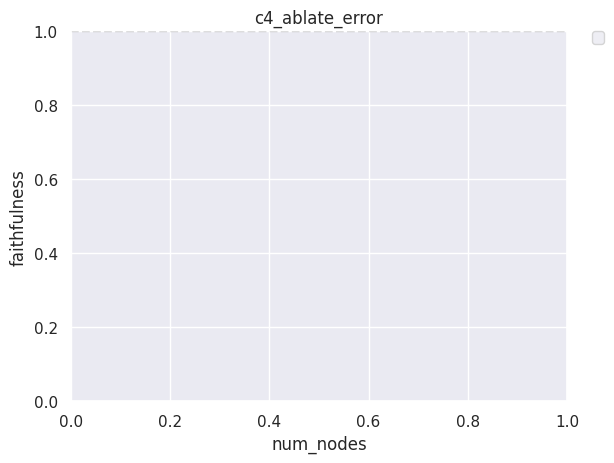

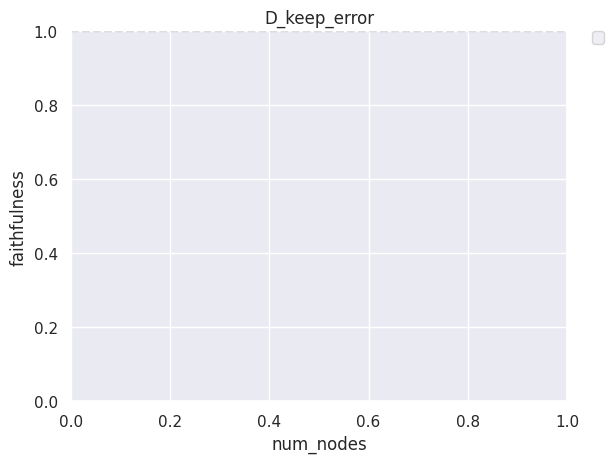

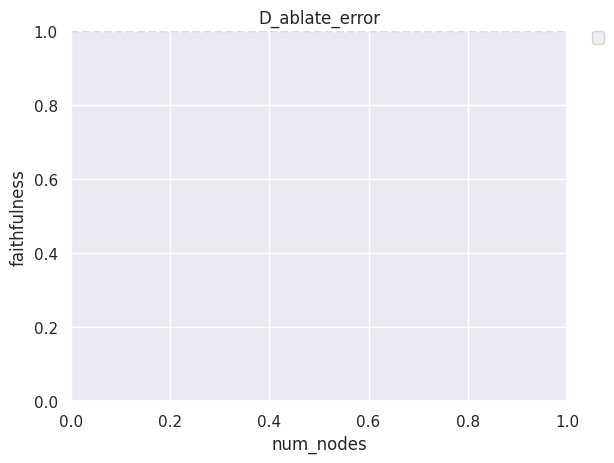

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

def make_plot_for_setting(df, sweep_name: str):
    fig, ax = plt.subplots()
    plot_df = df[(df.sweep_name == sweep_name)]
    sns.lineplot(data=plot_df, x="num_nodes", y="faithfulness", hue="dataset")
    ax.axhline(1, ls="--", color="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.title(sweep_name)

for sweep_name in SWEEP_NAMES:
    make_plot_for_setting(df, sweep_name)


# Noising & Denoising Curves

In [30]:
# Select a graph to load

result = load_result("ioi_BABA_template_0_prompts", 0.003, "corrupt_keep_error")
graph = result.graph
batch = result.batch
tokens = batch.clean

clean_tokens = batch.clean
corrupt_tokens = batch.corrupt

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/circuit-finder/results/corrupt_keep_error/dataset=ioi_BABA_template_0_prompts_threshold=0.003/result.pkl'

In [ ]:
nodes = [n for n in graph.get_src_nodes() if "metric" not in n]
print(len(nodes))

In [ ]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
import json 
from circuit_finder.metrics import batch_avg_answer_diff

def metric_fn(model, tokens):
    # Get the last-token logits
    logits = model(tokens)[:, -1, :]
    logit_diff = batch_avg_answer_diff(logits, batch)
    return logit_diff.mean()

In [ ]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import (
    splice_model_with_saes_and_transcoders,
    filter_sae_acts_and_errors,
    get_ablation_result,
)

with splice_model_with_saes_and_transcoders(
    model, transcoders, attn_saes
) as spliced_model:
    _, clean_cache = model.run_with_cache(
        clean_tokens, names_filter=filter_sae_acts_and_errors
    )
    _, corrupt_cache = model.run_with_cache(
        corrupt_tokens, names_filter=filter_sae_acts_and_errors
    )

noising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens=clean_tokens,
    corrupt_tokens=corrupt_tokens,
    clean_cache=clean_cache,
    corrupt_cache=corrupt_cache,
    nodes=nodes,
    metric_fn=metric_fn,
    setting="noising",
)

denoising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens=clean_tokens,
    corrupt_tokens=corrupt_tokens,
    clean_cache=clean_cache,
    corrupt_cache=corrupt_cache,
    nodes=nodes,
    metric_fn=metric_fn,
    setting="denoising",
)

In [ ]:
print(noising_result)

AblationResult(coefficient=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], metric=[0.5419864654541016, 1.2492303848266602, 1.7987756729125977, 2.282815933227539, 2.723536491394043, 3.085698127746582, 3.359137535095215, 3.5637407302856445, 3.746628761291504, 3.9386091232299805, 4.267216682434082])


In [ ]:
clean_metric = result.clean_metric
corrupt_metric = result.fully_ablated_metric

results = {
    "noising": noising_result,
    "denoising": denoising_result,
}

Text(0, 0.5, 'Metric')

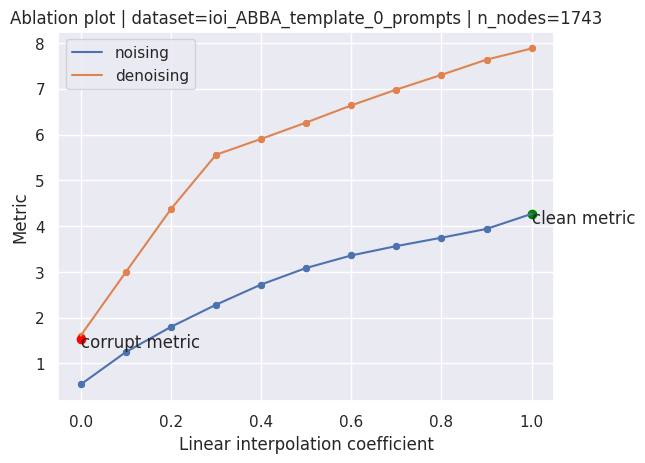

In [ ]:
# Plot the results

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
for setting, res in results.items():
    coefficients = res.coefficient
    metrics = res.metric
    sns.lineplot(x=coefficients, y=metrics, label=setting)
    sns.scatterplot(x=coefficients, y=metrics)
plt.legend()
# Add text
text_offset = -0.2
plt.scatter([1], [clean_metric], color="green")
plt.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
plt.scatter([0], [corrupt_metric], color="red")
plt.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

plt.title(f"Ablation plot | dataset={dataset_name} | n_nodes={len(nodes)}")
plt.xlabel("Linear interpolation coefficient")
plt.ylabel("Metric")